## Calculate the Mesozooplankton Trophic Level using Stock et al. 2014. 
\begin{equation}
MESO_{ZP} = ZPC * NPP * ZGE^{MESO_{TL}}
\end{equation}
    Where: 
- `MESOZP` = combined production of all zooplankton groups
- `NPP` = Net primary production 
- `ZGE` = mean of zooplankton growth efficiencies from the zooplankton gropus. It does provides a bulk measure of costumer growth efficiency for the system. 
- `ZPC` = zooplankton-phytoplankton coupling efficiency - total ingestion of phytoplankton by all zooplankton gropus divided by total phytoplankton produciton. 

In [51]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import seaborn as sns
import scipy.io as sio
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean

In [52]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [53]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [54]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

#### `Net primary production (NPP)` and `total primary production (TPP)` are both terms used to describe the process of converting solar energy into chemical energy through photosynthesis in plants. 
However, they differ in their specific definitions and what they represent.

- `Net Primary Production (NPP)`:
Net primary production refers to the total amount of energy or biomass that is produced by plants during photosynthesis, minus the amount of energy or biomass that is used by the plants for their own respiration (i.e., metabolic processes). In other words, NPP represents the energy or biomass that is available to support the growth and reproduction of primary producers (plants) in an ecosystem.
NPP takes into account the energy that is stored in plant tissues as organic matter (e.g., leaves, stems, roots) and can potentially be passed on to the next trophic level in the food chain. It is usually expressed in terms of energy (e.g., kilocalories per unit area) or biomass (e.g., grams per unit area) produced per unit area and per unit time (e.g., per year).

- `Total Primary Production (TPP)`:
Total primary production, on the other hand, refers to the total amount of energy or biomass that is produced by photosynthesis in an ecosystem, regardless of whether it is used by the plants themselves or stored as organic matter. TPP represents the entire amount of energy or biomass that is generated through photosynthesis.
TPP includes both the net primary production (NPP) and the energy or biomass that is consumed by plants through respiration (i.e., autotrophic respiration). It represents the total energy flow through the primary producer level in the ecosystem, including the energy that is retained by the plants for their own metabolic needs.

In summary, NPP specifically measures the energy or biomass available for growth and reproduction of plants, while TPP represents the total energy or biomass generated through photosynthesis, including what is used by the plants themselves. NPP is a more relevant measure when studying energy flow through ecosystems and assessing the potential productivity for higher trophic levels.

## Calculate `NPP`

##### `total primary production` and `total carbon fixation` refer to the same concept in ecology. 
Both terms describe the process by which green plants, algae, and some bacteria convert carbon dioxide (CO$_2$) and sunlight into organic matter through photosynthesis.

In [55]:
# Total C Fixation over the top 150m (Method 1)
total_prod = np.nansum(ds.photoC_TOT[:,:,:,:],axis=(0,1)) * 10 * (60*60*24*365) # mmol m-2 y-1
total_prod = total_prod * 12.011 / 1e3 # g/m^2/y

In [56]:
print('total phytoplankton production (Method 1) min is = ', np.nanmin(total_prod))
print('total phytoplankton production (Method 1) max is = ', np.nanmax(total_prod))

total phytoplankton production (Method 1) min is =  0.0
total phytoplankton production (Method 1) max is =  16290.093667197703


In [57]:
# Total C Fixation over the top 150m (Method 2)
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = ['photoC_'+v+'_zint' for v in phyto_names]
phytoProd = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoProd = ((phytoProd / 100)) # units are mmol m-3 * m s-1
phytoProd = np.nansum(phytoProd,axis=(0,1)) * (60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [58]:
print('total phytoplankton production (Method 2) min is = ', np.nanmin(phytoProd))
print('total phytoplankton production (Method 2) max is = ', np.nanmax(phytoProd))

total phytoplankton production (Method 2) min is =  0.0
total phytoplankton production (Method 2) max is =  16290.097900381745


#### Phytoplankton loss - linear loss and aggreagation loss 
- `linear loss` includes non-predation mortality and a collection of desnity-independent processes such as dissolved organic matter (DOM) exaudation, viral lysis, and cell death. 
- `aggregation loss` representes loss of phytoplankton due to aggregation and unresolved predation, and this loss goes directly to particulate organic matter (POC). 

In [59]:
# Loss Vertical Integral, mmol/m^3 cm/s
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'_loss_zint' for v in phyto_names]
phytoloss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoloss = ((phytoloss / 100)) # units are mmol m-3 * m s-1
phytoloss = np.nansum(phytoloss,axis=(0,1)) * (60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [60]:
print('total phytoplankton loss min is = ', np.nanmin(phytoloss))
print('total phytoplankton loss max is = ', np.nanmax(phytoloss))

total phytoplankton loss min is =  0.0
total phytoplankton loss max is =  1133.9570311078394


In [61]:
# Aggregation Vertical Integral, mmol/m^3 cm/s
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'_agg_zint' for v in phyto_names]
phytoagg = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoagg = ((phytoagg / 100)) # units are mmol m-3 * m s-1
phytoagg = np.nansum(phytoagg,axis=(0,1)) * (60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [62]:
print('total phytoplankton aggregation min is = ', np.nanmin(phytoagg))
print('total phytoplankton aggregation max is = ', np.nanmax(phytoagg))

total phytoplankton aggregation min is =  0.0
total phytoplankton aggregation max is =  10184.757175929488


In [63]:
total_npp = phytoProd- phytoloss

In [64]:
print('NPP min is = ', np.nanmin(total_npp))
print('NPP max is = ', np.nanmax(total_npp))

NPP min is =  0.0
NPP max is =  15156.140869273906


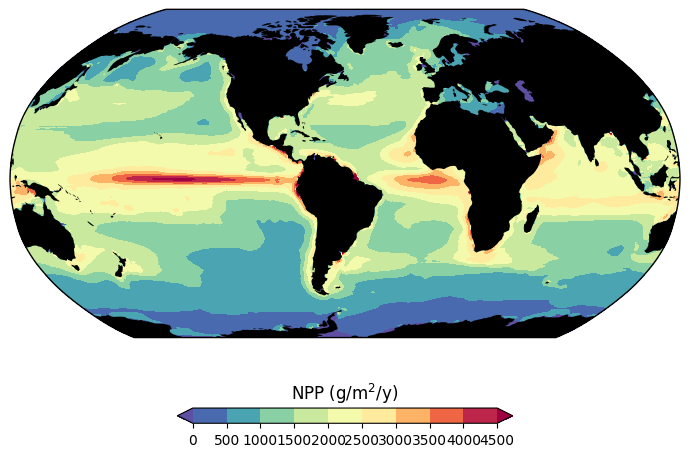

In [65]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 5000, 500)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2500)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('NPP (g/m$^2$/y)')
#cb.ax.tick_params(labelsize=16)
fig.tight_layout()

## Calculate `MESOZP` = mesozooplankton production not consumed by other zooplankton
* Here, I will use zooplankton production - zooplankton grazing on zooplankton of each category

In [66]:
# sum of Zooplankton Grazing Gain Vertical Integral mol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooGraz'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_names], dim='var')* 1e-2 # units are mmol m-2 s-1
zooGraz = np.nansum(ds.zooGraz,axis=1) *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y
zooGraz_TOT = np.nansum(zooGraz, axis=0)

In [129]:
# zooplankton loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooLoss'] = xr.concat([ds[''+ v + '_loss_zint'] for v in zoo_names], dim='var')* 1e-2 # units are mmol m-2 s-1
zooloss = np.nansum(ds.zooLoss,axis=1) *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y
zooloss_TOT = np.nansum(zooloss, axis=0)

In [130]:
# zooplankton Linear loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooLoss'] = xr.concat([ds[''+ v + '_linear_loss_zint'] for v in zoo_names], dim='var')* 1e-2 # units are mmol m-2 s-1
zoo_lin_loss = np.nansum(ds.zooLoss,axis=1) *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y
zoo_lin_loss_TOT = np.nansum(zoo_lin_loss, axis=0)

In [131]:
zooProduction = np.subtract(zooGraz_TOT, zooloss_TOT)
zooProduction[zooProduction<0]=0

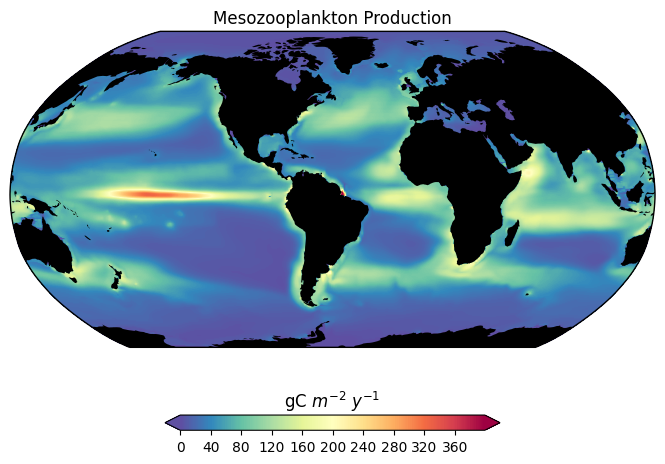

In [69]:
lev = np.arange(0, 400, 1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=200)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooProduction)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('gC $m^{-2}$ $y^{-1}$')
ax.set_title('Mesozooplankton Production');
plt.tight_layout()

In [70]:
print('mesozooplankton production min is = ', np.nanmin(zooProduction))
print('mesozooplankton production  max is = ', np.nanmax(zooProduction))

mesozooplankton production min is =  0.0
mesozooplankton production  max is =  470.64547179939063


## Calculate `ZGE` = mean of mesozooplankton growth efficiencies from the zooplankton groups. It does provides a bulk measure of costumer growth efficiency for the system. 

The `Zooplankton Growth Efficiency` is the ratio of net zooplankton production to ingestion, is thus negative at very low ingestion rates (i,e) there is a net loss of carbon to respiration) before increasing toward an asympotic maximum just below 40% as in observations of Straile (1997) and Hansen et al. (1997). 

\begin{equation}
ZGE = \frac{net~zooplankton~production}{ingestion}
\end{equation}

### Calculate mesozooplankton ingestion

#### Zooplankton 3

In [71]:
graze_zoo3 = ['diaz_zoo3','mp2_zoo3','mp3_zoo3',
               'diat1_zoo3','diat2_zoo3','diat3_zoo3',
               'zoo1_zoo3','zoo2_zoo3']

graze_vars = ['graze_'+v+'' for v in graze_zoo3]
ingestion_zoo3 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo3 = np.nansum(ingestion_zoo3[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo3 = np.nansum(ingestion_zoo3,axis=0) * (60*60*24*365) # mmol C m-2 yr-1

#### Zooplankton 4

In [72]:
graze_zoo4 = ['mp2_zoo4','mp3_zoo4',
             'mp4_zoo4','diat1_zoo4','diat2_zoo4','diat3_zoo4','zoo2_zoo4','zoo3_zoo4']

graze_vars = ['graze_'+v+'' for v in graze_zoo4]
ingestion_zoo4 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo4 = np.nansum(ingestion_zoo4[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo4 = np.nansum(ingestion_zoo4,axis=0) * (60*60*24*365) * 1.2011e-2 # to g C / m^2 y

#### Zooplankton 5

In [73]:
graze_zoo5 = ['mp3_zoo5','mp4_zoo5','diat2_zoo5','diat3_zoo5',
            'zoo3_zoo5','zoo4_zoo5']

graze_vars = ['graze_'+v+'' for v in graze_zoo5]
ingestion_zoo5 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo5 = np.nansum(ingestion_zoo5[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo5 = np.nansum(ingestion_zoo5,axis=0) * (60*60*24*365) * 1.2011e-2 # to g C / m^2 y

#### Zooplankton 6 

In [74]:
graze_zoo6 = ['mp4_zoo6','diat3_zoo6','zoo4_zoo6','zoo5_zoo6']

graze_vars = ['graze_'+v+'' for v in graze_zoo6]
ingestion_zoo6 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo6 = np.nansum(ingestion_zoo6[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo6 = np.nansum(ingestion_zoo6,axis=0) * (60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [75]:
# Ingestion rates for individual zooplankton 
inegestion_zoo = np.stack([ingestion_zoo3,ingestion_zoo4,ingestion_zoo5,ingestion_zoo6],axis=0)

In [76]:
print('mesozooplankton ingestion min is = ', np.nanmin(inegestion_zoo))
print('mesozooplankton ingestion  max is = ', np.nanmax(inegestion_zoo))

mesozooplankton ingestion min is =  0.0
mesozooplankton ingestion  max is =  53180.464865639806


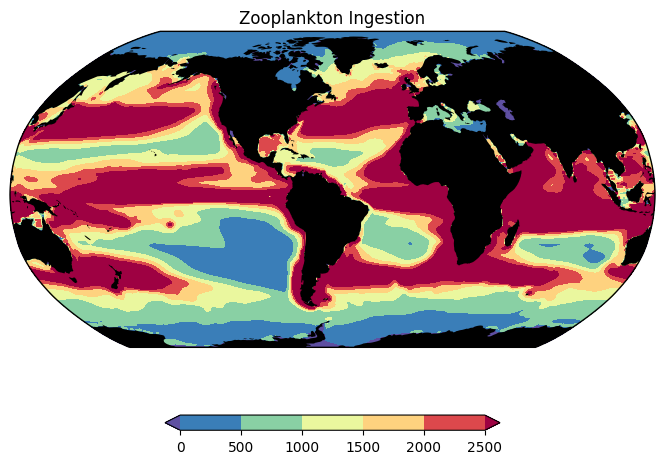

In [77]:
lev = np.arange(0, 3000, 500)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=1500)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(inegestion_zoo,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Zooplankton Ingestion');
plt.tight_layout()

## Calculate mesozooplankton production

In [132]:
## mesozooplankton Production for individual zooplankton 
zooProd = np.subtract(zooGraz, zooloss)
zooProd[zooProd<0]=0

In [133]:
print('mesozooplankton production min is = ', np.nanmin(zooProd))
print('mesozooplankton production  max is = ', np.nanmax(zooProd))

mesozooplankton production min is =  0.0
mesozooplankton production  max is =  279.2127497444619


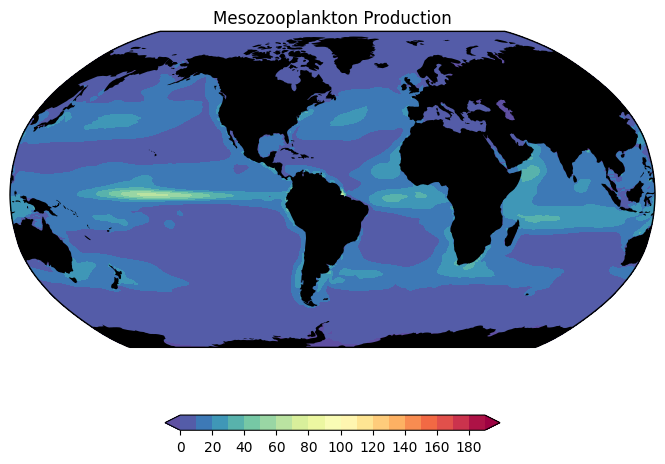

In [134]:
lev = np.arange(0, 200, 10)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=100)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooProd,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Mesozooplankton Production');
plt.tight_layout()

## Calculate mesozooplankton growth efficiency
- In total, ~30% of ingested material is egested, yielding an assimilation efficiency (ae) of 70% (Carlotti et al. 2000; Nagata, 2000). An additional 30% of ingestion is allocated to active metabolism (i.e., metabolic costs associated with feeding), leaving 40% to cover basel metabolic costs and support production (i.e., growth and reproduction). 

In [138]:
# Calculate the zooplankton growth efficiency
ZGE_zoo = (zooProd/inegestion_zoo)
ZGE = np.nanmean(ZGE_zoo,axis=0)

In [139]:
print('ZGE_zoo min is = ', np.nanmin(ZGE_zoo))
print('ZGE_zoo max is = ', np.nanmax(ZGE_zoo))
print('ZGE min is = ', np.nanmin(ZGE))
print('ZGE max is = ', np.nanmax(ZGE))

ZGE_zoo min is =  0.0
ZGE_zoo max is =  1212.518184843966
ZGE min is =  0.0
ZGE max is =  303.4671747378489


Zooplankton growth efficiency refers to the efficiency with which zooplankton convert the energy they obtain from consuming phytoplankton or other food sources into their own biomass growth. It is typically expressed as the ratio of zooplankton biomass production to the biomass of the food they consume.

If the zooplankton growth efficiency is greater than 1, it implies that the zooplankton are producing more biomass than the amount of food they consume. This scenario is generally not observed in natural ecosystems because it would violate the principle of energy conservation. According to the laws of thermodynamics, energy cannot be created or destroyed, only transformed or transferred.

However, it's important to note that there might be instances where apparent growth efficiency exceeds 1 due to factors such as measurement errors or incomplete understanding of the system. In reality, the growth efficiency of zooplankton is typically less than 1, indicating that they convert only a fraction of the energy they consume into their own biomass growth. This inefficiency is attributed to metabolic losses, respiration, and energy expenditures for various physiological processes, locomotion, and reproduction.

In summary, if the zooplankton growth efficiency is reported to be greater than 1, it is likely an anomaly or an error in measurement rather than a reflection of actual biological processes.

In [140]:
print('ZGE min is = ', np.nanmin(ZGE))
print('ZGE max is = ', np.nanmax(ZGE))

ZGE min is =  0.0
ZGE max is =  303.4671747378489


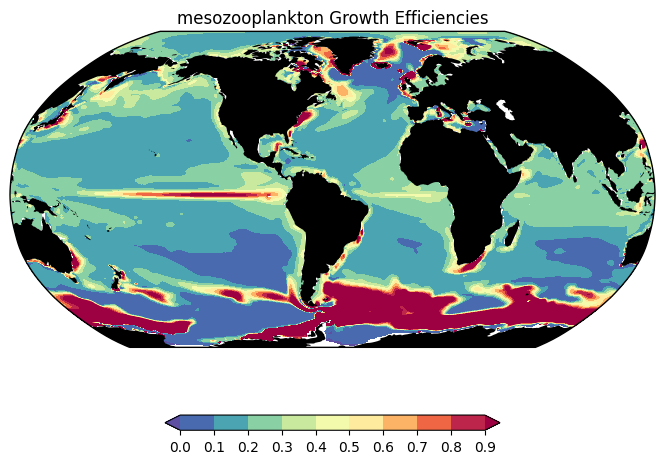

In [141]:
lev = np.arange(0, 1, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, ZGE)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('mesozooplankton Growth Efficiencies');
plt.tight_layout()

#### NOTE: Compared to `Stock et al. 2014` the zooplankton growth efficiencies are higher here ranging from 0 to greater than 1, which does not make sense. In `Stock et al. 2014` they range from 0 to 0.4, the regional distribution is consistents but the values do not match up completely, so if there is something wrong it could be the way that i calculated these growth efficienties.  

## Calculate `ZPC`= zooplankton-phytoplankton coupling efficiency  
The `zooplankton–phytoplankton coupling (ZPC) efficiency` is the total ingestion of phytoplankton by all zooplankton groups divided by total phytoplankton production. It reflects the extent of consumer–prey coupling in the pelagic system.

In [142]:
graze_names = ['diaz_zoo1','diaz_zoo2','diaz_zoo3','pp_zoo1','mp1_zoo1','mp1_zoo2',
            'mp2_zoo2','mp2_zoo3','mp2_zoo4','mp3_zoo3','mp3_zoo4','mp3_zoo5',
             'mp4_zoo4','mp4_zoo5','mp4_zoo6','diat1_zoo1','diat1_zoo2','diat1_zoo3',
            'diat1_zoo4','diat2_zoo2','diat2_zoo3','diat2_zoo4','diat2_zoo5',
             'diat3_zoo3','diat3_zoo4','diat3_zoo5','diat3_zoo6']

graze_vars = ['graze_'+v+'' for v in graze_names]
ingestion = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion = np.nansum(ingestion[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion = np.nansum(ingestion,axis=0) * (60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [143]:
print('ingestion min is = ', np.nanmin(ingestion))
print('ingestion max is = ', np.nanmax(ingestion))
print('phytoProd min is = ', np.nanmin(phytoProd))
print('phytoProd max is = ', np.nanmax(phytoProd))

ingestion min is =  0.0
ingestion max is =  919.7099426186644
phytoProd min is =  0.0
phytoProd max is =  16290.097900381745


In [144]:
ZPC = (ingestion/phytoProd)

In [145]:
print('ZPC min is = ', np.nanmin(ZPC))
print('ZPC max is = ', np.nanmax(ZPC))

ZPC min is =  0.04492295520317772
ZPC max is =  0.3772981937385583


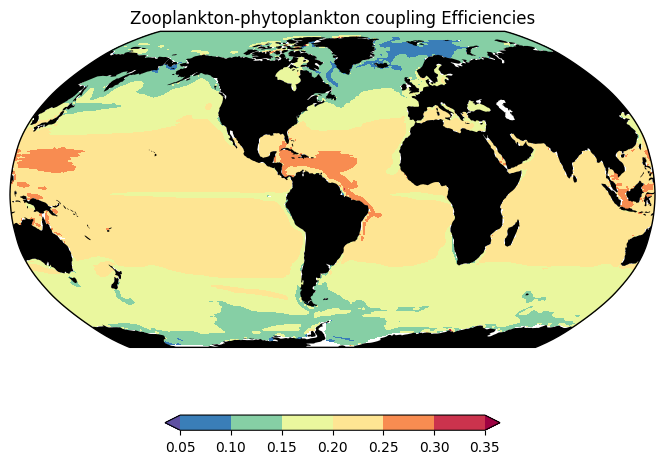

In [118]:
lev = np.arange(0, 40, 1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=20)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, ZPC)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Zooplankton-phytoplankton coupling Efficiencies');
plt.tight_layout()

## Calculate the trophic level 
\begin{equation}
MESO_{TL} = \frac{ln(\frac{MESO_{ZP}}{(ZPC*NPP)})}{ln(ZGE)}
\end{equation}

In [146]:
nominator = zooProduction/(ZPC*total_npp)
denominator = ZGE

In [147]:
print('nominator min is = ', np.nanmin(nominator))
print('nominator max is = ', np.nanmax(nominator))
print('denominator min is = ', np.nanmin(denominator))
print('denominator max is = ', np.nanmax(denominator))

nominator min is =  0.0
nominator max is =  0.594882276526386
denominator min is =  0.0
denominator max is =  303.4671747378489


In [148]:
nominator[nominator==0]=1
denominator[denominator==0]=1

In [149]:
log_nominator = ma.log(nominator)
log_denominator = ma.log(denominator)

In [150]:
print('log_nominator min is = ', np.nanmin(log_nominator))
print('log_nominator max is = ', np.nanmax(log_nominator))
print('log_denominator min is = ', np.nanmin(log_denominator))
print('log_denominator max is = ', np.nanmax(log_denominator))

log_nominator min is =  -8.021226240404424
log_nominator max is =  0.0
log_denominator min is =  -13.60514579711163
log_denominator max is =  5.715273448926574


In [151]:
zoo_TL = log_nominator/log_denominator

In [152]:
print('zoo_TL min is = ', np.nanmin(zoo_TL))
print('zoo_TL max is = ', np.nanmax(zoo_TL))

zoo_TL min is =  -11318.853537870395
zoo_TL max is =  11150.186592169317


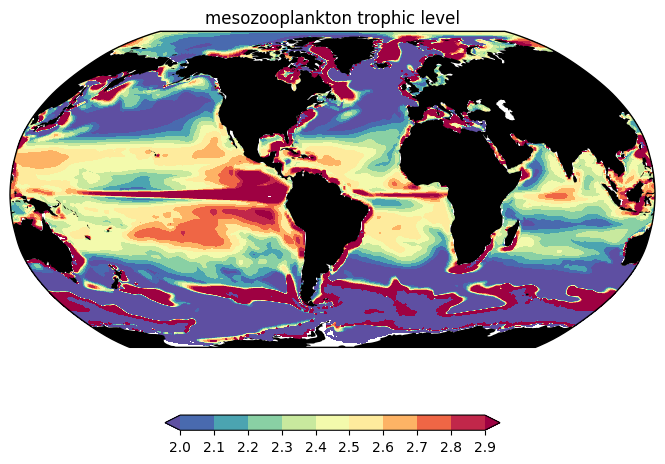

In [155]:
lev = np.arange(2, 3, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, 1+zoo_TL)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels = lev, norm = norm,extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('mesozooplankton trophic level');
plt.tight_layout()